# Predicting the Number of Bikes Rented in Seoul within an Hour

Catherine Al Aswad  (305541); CS4120: Machine Learning, Data Mining, Assignment 2; Date: 19 March 2021

## Abstract:

With the growing populatrity of the Seoul Bike Sharing System, the Seoul Metropolitan Government needs to keep up with the demand of bicycles. This report tries to find an appropriate model to predict the number of bikes rented within an hour, as part of the Seoul Bike Sharing System, so that the government can estimate future bike demand. The report uses a linear regression approach, with the aid of regularization, feature scaling, and feature selection techniques to build many models and analyse them. Cross-validation and the train-test split approaches are used to check the adequacy of these models. The model with the most promising results uses the features 'Hour', 'Temperature(°C)', 'Humidity(%)', and 'Wind speed (m/s)' to predicting the number of bikes rented in an hour. This model is non-linear and explains about 70% of the variability of the response variable in question.  


## Introduction: Motivation and Goal

This project uses the 'Seoul Bike Sharing Demand Data Set' from the UCI repository [1](UCI,https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand). The motive for choosing this dataset is that the data is about a relatively recent and ongoing initiative started by the Seoul governement, making observations found from this dataset relevant.  

The goal of this report is to predict the number of public bikes rented in Seoul within an hour, using data from 2017 and 2018. A linear regression approach is taken to predict the continous variable. With the increase in popularity of the Sytem among the residence in Seoul, predicting the number of bikes rented under certain conditions can help the SMG improve the services of the Seoul Bike Sharing System.

## Background:

### The Dataset:

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
random.seed(4)

In [2]:
# reading the dataset and only the columns we want:
SeoulBikeData = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')
SeoulBikeDataTidy = SeoulBikeData[['Rented Bike Count', 'Hour', 'Temperature(°C)', 
                                   'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)', 
                                   'Seasons', 'Holiday', 'Functioning Day', 
                                   'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']]


# To show that there is no bike renting on non-functional days:
# SeoulBikeDataTidy.pivot_table('Rented Bike Count',
#                              index = 'Functioning Day',
#                              aggfunc = 'sum')

# keeping on the data on functional days:
SeoulBikeDataTidy = SeoulBikeDataTidy.loc[SeoulBikeDataTidy['Functioning Day']=='Yes']

In [3]:
# checking for missing values:
SeoulBikeDataTidy = SeoulBikeDataTidy.replace(r'^\s*$', np.nan, regex=True)
## SeoulBikeDataTidy.isna().sum()

This project uses the 'Seoul Bike Sharing Demand Data Set' from the UCI repository [1]. The dataset contains information about the count of public bikes rented and weather conditions at each hour in Seoul's Bike Sharing System from 2017 and 2018. The Seoul Bike Sharing System was started by the Seoul Metropolitan Government (SMG) to reduce traffic and pollution in the city [2]. The original features from the dataset that are used in the report are:

Hour: Hour of the day; Temperature(°C); Humidity(%); Wind speed (m/s); Dew point temperature(°C);
Seasons: Winter, Spring, Summer, Autum; Holiday: Holiday/No holiday; Visibility (10m); Solar Radiation (MJ/m2); Rainfall(mm); Snowfall (cm)

The 'Date' variable from the dataset will not be considered, since the focus is on the hour rather than the specific year-month-day date. Also, there is a 'Functional Day' feature that will be held constant at 'Fun(Functional hours)', since no bikes are rented when there are no functional hours. There is no missing data in the dataset and by considering only functional days, we are using 8465 observations of the original 8760 observations (96.6% of the original dataset).

From the table below, we see that the label of interest 'Rented Bike Count', although discrete, has a wide range of values and large standard deviation. This label has no identified upper limit, since future data can have a Rented Bike Count go beyond 3556 bikes. Also, the min = 25% = 50% = 75% = 0 for the Rainfall and Snowfall features, with each having large maximums. This indicates that the features have a heavily right skewed distribution.

In [4]:
# getting a summary of the data:
SeoulBikeDataTidy.drop(["Seasons", "Holiday", "Functioning Day"], axis=1).describe(include= 'all').round(1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Dew point temperature(°C),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8465.0,8465.0,8465.0,8465.0,8465.0,8465.0,8465.0,8465.0,8465.0,8465.0
mean,729.2,11.5,12.8,58.1,1.7,3.9,1433.9,0.6,0.1,0.1
std,642.4,6.9,12.1,20.5,1.0,13.2,609.1,0.9,1.1,0.4
min,2.0,0.0,-17.8,0.0,0.0,-30.6,27.0,0.0,0.0,0.0
25%,214.0,6.0,3.0,42.0,0.9,-5.1,935.0,0.0,0.0,0.0
50%,542.0,12.0,13.5,57.0,1.5,4.7,1690.0,0.0,0.0,0.0
75%,1084.0,18.0,22.7,74.0,2.3,15.2,2000.0,0.9,0.0,0.0
max,3556.0,23.0,39.4,98.0,7.4,27.2,2000.0,3.5,35.0,8.8


It was found that Dew Point Temperature and Temperature are strongly correlated (0.91). Also, Humidity is strongly correlated with Visibility (-0.55) and Solar Radiation (-0.46) , but Visibility and Solar Radiation have a weak correlation. These strong correlations may cause problems in the model fitting process.


In the set of graphs below, the rented bike count is plotted against each of the continous features previously mentioned. The first graph is a histogram for the rented bike counts, which appears heavily right skewed. The rented bike count appears to have a positive correlation with hour, temperature, and visibility. The rented bike count appears to have a negative correlation with wind speed. The relationship with the rented bike count and humidity, solar raiation, rainfall, and snowfall are not clear.

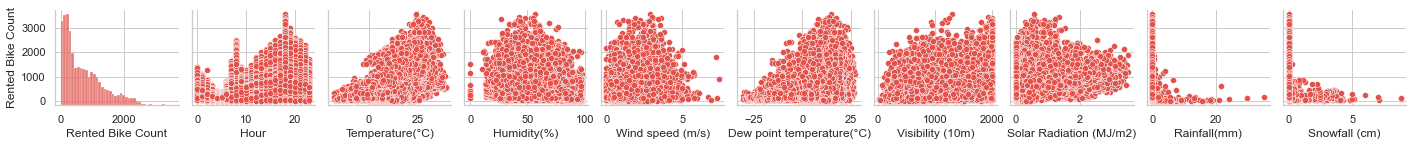

In [5]:
sns.set_style("whitegrid")
sns.set_palette("Spectral")
sns.pairplot(SeoulBikeDataTidy, height = 2,
            y_vars='Rented Bike Count')

The left boxplot below shows that Summmer is the peak season for renting bikes, while not many are rented in the winter. The right boxplot shows that more bikes are rented during the holidays. Both graphs below show many outliers. The effect of the outliers will be reduced by taking the square root of the rented bike count, so that the label has an approximately normal distribution. Tthe square root is a simple transformation that is not hard to interpret.

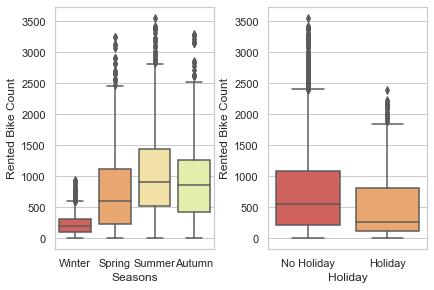

In [6]:
fig, ax =plt.subplots(1,2)

sns.boxplot(x="Seasons", y="Rented Bike Count",
                 data=SeoulBikeDataTidy, ax=ax[0])
sns.boxplot(x="Holiday", y="Rented Bike Count",
                 data=SeoulBikeDataTidy , ax=ax[1])
fig.tight_layout(pad=0.5)


In [7]:
SeoulBikeDataTidy['TransfRBC'] = SeoulBikeDataTidy['Rented Bike Count'].pow(1/2)

### The machine learning techniques used:

The report fits the data to linear regression models. To obtain a flexible model, higher degree polynomial terms are explored for the original 11 features with their interactions. All the features used in the models have varying and distinct ranges. That is handled by standardinzing the features for the larger more complex model designs, and normalizing the features for the reduced model designs.


The best polynomial degree for the features is learnt by comparing models of varying polynomial degrees using their training Mean Squared Error and testing MSE. The models are trained with 80% of the data, and tested with the remaining 20%. The 10-fold cross-validation approach is also used to get a more accurate analysis of the models' adequacy.

To check for signs of overfitting and underfitting in the model, learning curves are plotted. For signs of overfitting, certain features are dropped from the model for reasons related to the bike rental system, and are compared against the full model to check for improvements. Additionally, the many polynomial and interaction terms create a high feature dimension for the model, which cause overfitting. The Ridge Regression technique is used to regularize the terms in the model to reduce the overflexibility of the model. The best regularization value, alpha, is learnt through 5-fold cross-validation. 

## Model Analysis:

In order to reduce the effect of the outliers found earlier, the model will be selected such that it predicts the square root rented bike count.

### 1 - Full Model:

The Full Model includes the 11 original feautures. Polynomial regression models upto degree 4 with interactions are explored. The categorical variables are turned into dummy variables to be used in the regression model. The distinct ranges of the continuous variables are standardized (applied feature scaling). Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

In [8]:
# designSummary : fits a linear regression model, with standard scaling, for all upper degree terms and interactions.
# Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

# Xdata : feature data, input
# ydata : label data, input
# polyDegree: highest polynomial degree to explore, input

# summary : returns a table, with cross-validation mse, train and test mse, polynomial degree, and train and test data R^2 values

def designSummary(Xdata, ydata, polyDegree):
    d_range = list(range(1, polyDegree))
    linreg = LinearRegression()
    summary = pd.DataFrame(columns = ['ModelDegree','CVMSE', 'TrainMSE', 'TestMSE', 'train R^2', 'test R^2'])

    for d in d_range:
        poly = PolynomialFeatures(degree=d)
        scaler = StandardScaler()
        fitTransf = poly.fit_transform(Xdata)
        fitTransf = scaler.fit_transform(fitTransf)
        
        CVscore = -1*cross_val_score(linreg, fitTransf, ydata, cv=10, scoring='neg_mean_squared_error').mean()

        X_train, X_test, y_train, y_test = train_test_split(fitTransf, ydata, test_size=0.2, random_state=4)
        linreg.fit(X_train, y_train)
        y_testpred = linreg.predict(X_test)
        y_trainpred = linreg.predict(X_train)
        
        trainScore = metrics.mean_squared_error(y_train, y_trainpred)
        testScore = metrics.mean_squared_error(y_test, y_testpred)

        test_acc = linreg.score(X_test, y_test)
        train_acc = linreg.score(X_train, y_train)
    
        summary.loc[len(summary.index)] = [d, CVscore, trainScore, testScore, train_acc, test_acc]  

    summary['ModelDegree'] = summary['ModelDegree'].astype(np.int64).astype(str)

    return summary
    

In [9]:
# MSEplot : plots the MSE vs polynomial degree plot using the input table from the designSummary() funtion 
# design : table from the designSummary( function)
def MSEplot(design):
    plt.plot(design['ModelDegree'], design['CVMSE'],'k', label='MSE with 10-fold Crossvalidation')
    plt.plot(design['ModelDegree'], design['TestMSE'],'b', label='MSE on the TEST set')
    plt.plot(design['ModelDegree'], design['TrainMSE'],'r', label='MSE on the TRAIN set')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel('Polynomial degree')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE')
    plt.show()


In [10]:
# learningCurve : gives data that can be used to plot the learning curve for a linear regression model,
#  with standard scaling, for all upper degree terms and interactions; 
# 10-fold cross validation is used to train and test the model.

# Xdata : feature data, input
# ydata : label data, input
# polyDegree : polynomial degree for the model, input
# trDataSizes : list of sizes for the training data

# LCdata :  a table with the training set size and corresponding training MSE and validation MSE 

def learningCurve(Xdata, ydata, trDataSizes, polyDegree):
    linreg = LinearRegression()
    poly = PolynomialFeatures(degree= polyDegree)
    scaler = StandardScaler()
    fitTransf = poly.fit_transform(Xdata)
    fitTransf = scaler.fit_transform(fitTransf)
    
    train_sizes, train_scores, val_scores = learning_curve(estimator = linreg, X = fitTransf,
                                                       y = ydata, train_sizes = trDataSizes, cv = 10,
                                                       scoring='neg_mean_squared_error', random_state = 4)

    train_scores_mean = -train_scores.mean(axis = 1)
    val_scores_mean = -val_scores.mean(axis = 1)
    
    LCdata = pd.DataFrame({'trSetSize' : trDataSizes , 'trMSE' : train_scores_mean, 'valMSE' : val_scores_mean })
    
    return LCdata

The graph and table below show that the error from the 10-fold cross validation is low for polynomial degree 1, then increases rapidly (~ 2.4 x 1e23) at polynomial degree 2, then decreases again. In contrast, the error from the test and train sets are significantly smaller than the MSE from the cross-validation for all 4 models. The behaviour of the MSE for the models of small degree is unusual since high bias is expected for lower polynomial degrees; instead there is high variance, which is a sign of overfitting and is problematic.

In [11]:
features = ['Hour', 'Temperature(°C)', 
          'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)' ,  
          'Seasons', 'Holiday'  ,
          'Visibility (10m)', 'Solar Radiation (MJ/m2)' , 
          'Rainfall(mm)', 'Snowfall (cm)'
           ]
X = SeoulBikeDataTidy[features]
X = pd.get_dummies(data=X, drop_first=True)
Y = SeoulBikeDataTidy[['TransfRBC']]
design1 = designSummary(X,Y,5)
design1

,ModelDegree,CVMSE,TrainMSE,TestMSE,train R^2,test R^2
0,1,6.105488e+01,52.826010,5.731558e+01,0.622940,5.978341e-01
1,2,2.465720e+23,36.082889,4.388986e+01,0.742449,6.920383e-01
2,3,5.432072e+19,22.058355,6.417592e+02,0.842553,-3.503028e+00
3,4,1.366497e+22,13.840818,2.234698e+22,0.901208,-1.568019e+20


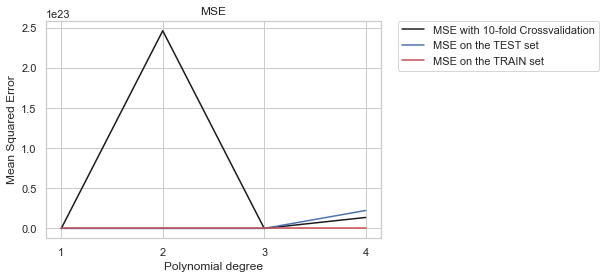

In [12]:
MSEplot(design1)

### 2 - Feature Slection Part 1:

Due to the overfitting done by the Full Model, the categorical variables (Season and Holiday) are removed from the model to check if they are significant features in the model. 

Polynomial regression models upto degree 4 with interactions are explored. The distinct ranges of the continuous variables are standardized. Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

The table below shows that the spike in MSE with the 10-fold crossvalidation is no longer there for low polynomial degrees. Instead, there is a steady decrease in MSE before 2 degrees, and then a instant increase after 2 degrees. However, the crossvalidation MSE at the elbow of the crossvalidation curve is still excessivly larger than the MSE of the training set. 

Due to the positive effect that removing the Seasons and Holidays features has on the model, the two features will be removed in the next phase of feature selection.

In [13]:
features = ['Hour', 'Temperature(°C)', 
          'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)' ,  
          'Visibility (10m)', 'Solar Radiation (MJ/m2)' , 
          'Rainfall(mm)', 'Snowfall (cm)']
X = SeoulBikeDataTidy[features]
X = pd.get_dummies(data=X, drop_first=True)
Y = SeoulBikeDataTidy[['TransfRBC']]
design2 = designSummary(X,Y,5)
design2

,ModelDegree,CVMSE,TrainMSE,TestMSE,train R^2,test R^2
0,1,6.642945e+01,58.512507,6.363613e+01,0.582352,5.534847e-01
1,2,6.333673e+01,42.309342,4.977257e+01,0.698006,6.507611e-01
2,3,9.553383e+01,27.645036,1.252881e+02,0.802676,1.208916e-01
3,4,2.504434e+22,19.830459,5.167740e+21,0.858455,-3.626045e+19


Regardless of the aformentioned improvement, this reduced model shows slight overfitting. The table below shows the train and test MSE for some training set sizes, for the polynomial model to degree 2. The MSE difference between the train and validation datasets is slightly large for the large training sample sizes. So, the model suffers from slight high variance (slight overfitting), but not high bias (no underfitting). 


In [14]:
train_sizes = range(1,1900, 10 )
learnningCurveData2 = learningCurve(X,Y,train_sizes, 2)
learnningCurveData2.tail(5)

,trSetSize,trMSE,valMSE
185,1851,14.380036,127.189465
186,1861,14.502720,130.829515
187,1871,14.529084,138.923448
188,1881,14.588621,138.309850
189,1891,14.593728,137.601033


### 3 - Feature Slection Part 2:

To simplify the model even more, the following variables are removed from this model: Dew point temperature(°C); Rainfall(mm); Snowfall (cm); Visibility (10m); Solar Radiation (MJ/m2).

Visibility (10m) and Solar Radiation (MJ/m2) are removed since Humidity is strongly correlated with both of them, but Visibility and Solar Radiation have a low corrlation. Dew point temperature(°C) is removed since it is strongly correlated with Temperature. It is assumed that a citizen is more likely aware of the temperature rather than the Dew point temperature, so the former feature more logically affects a citizen's decision to go and rent a bike. These high correlations may be causing multicollinearity, which is problematic.

Rainfall(mm) and Snowfall (cm) are removed since they have a heavily skewed distribution. The heavily skewed nature of the data is problematic since more than 75% of the observations have a value of 0 rainfall and 0 snowfall, but a wide range of rented bike counts.  

Polynomial regression models upto degree 6 with interactions are explored. The distinct ranges of the continuous variables are standardized. Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

The table below shows that removing the 5 features above resulted in a lower MSE for each of the train, test, and crossvalidation sets. The model design is best for a polynomial degree of 5, since that is where the crossvalidation MSE is at a minimum.

In [15]:
features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
X = SeoulBikeDataTidy[features]
Y = SeoulBikeDataTidy[['TransfRBC']]
design3 = designSummary(X,Y,7)
design3

,ModelDegree,CVMSE,TrainMSE,TestMSE,train R^2,test R^2
0,1,68.778068,62.661341,66.891154,0.552738,0.530645
1,2,55.836760,48.688911,52.219308,0.652470,0.633593
2,3,42.911544,37.913949,41.988778,0.729379,0.705378
3,4,39.774961,35.035808,39.138682,0.749923,0.725376
4,5,37.882058,30.024596,34.616337,0.785692,0.757108
5,6,54.699522,28.801144,34.702254,0.794424,0.756505


The table below shows the train and test MSE for some training set sizes, for the polynomial model to degree 5. The differences in the test and validation MSE from this model are greater that the MSE differences of the previous model, for the large training set sizes below. This model suffers from high variance (overfitting), but not high bias (no underfitting). 

In [16]:
train_sizes = range(1,1900, 10 )
learnningCurveData3 = learningCurve(X,Y,train_sizes, 5)

In [17]:
learnningCurveData3.tail(5)

,trSetSize,trMSE,valMSE
185,1851,12.359493,74749.021130
186,1861,14.507407,156667.371480
187,1871,12.593104,73568.407616
188,1881,15.448373,116265.689610
189,1891,12.454223,58095.999315


### 4 - Handeling Overfitting:

The overfitting in the previous model may be due to having a high feature dimension: 4 original features in the model upto degree 5, with all the interactions between theses 20 polynomial features. This section explores polynomial regression models upto degree 6, without interactions. The distinct ranges of the continuous variables are normalized. Ridge Regression Regularization is implemented to reduce the overflexibility of the model. The optimal degree of regularization is learned through 5-fold crossvalidation. Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

In [18]:
# designSummary3 : fits a linear regression model, normalized the features, 
# applies ridge regularization with 5-fold cross-validation, for all upper degree terms with no interactions.
# Two approaches are taken for training and testing the models: 10-fold cross-validation and a test-training split (20%-80% split).

# Xdata : feature data, input
# ydata : label data, input
# polyDegree: highest polynomial degree to explore, input
# alpha_range : range of ridge regularization values to test on the models, from which an optimal one is chosen.

# summary : returns a table, with cross-validation mse, train and test mse, polynomial degree, 
#  and train and test data R^2 values, and best regularization alpha score


def designSummary3(Xdata, ydata, polyDegree, alpha_range):
    d_range = list(range(1, polyDegree))
    ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error', cv = 5)
    summary = pd.DataFrame(columns = ['ModelDegree', 'Best Alpha','CVMSE', 'TrainMSE', 'TestMSE', 'train R^2', 'test R^2'])

    
    for d in d_range:
        poly = PolynomialFeatures(degree=d)
        fitTransf = poly.fit_transform(Xdata)
        allFeatures = pd.DataFrame(poly.get_feature_names(Xdata.columns))
        noInteractions = allFeatures[~allFeatures[0].str.contains(' ')][0].to_list()
        
        fitTransf2 = pd.DataFrame(fitTransf)
        fitTransf2.rename(columns=dict(zip(fitTransf2.columns, poly.get_feature_names(Xdata.columns))), inplace=True)
        fitTransf = fitTransf2[noInteractions]
        
        CVscore = -1*cross_val_score(ridgeregcv, fitTransf, ydata, cv=10, scoring='neg_mean_squared_error').mean()

        X_train, X_test, y_train, y_test = train_test_split(fitTransf, ydata, test_size=0.2, random_state=4)
        ridgeregcv.fit(X_train, y_train)
        bestAlpha = ridgeregcv.alpha_
        y_testpred = ridgeregcv.predict(X_test)
        y_trainpred = ridgeregcv.predict(X_train)
        
        trainScore = metrics.mean_squared_error(y_train, y_trainpred)
        testScore = metrics.mean_squared_error(y_test, y_testpred)

        test_acc = ridgeregcv.score(X_test, y_test)
        train_acc = ridgeregcv.score(X_train, y_train)
    
        summary.loc[len(summary.index)] = [d,bestAlpha, CVscore, trainScore, testScore, train_acc, test_acc]  

    summary['ModelDegree'] = summary['ModelDegree'].astype(np.int64).astype(str)
   
    return  summary
    


In [19]:
# learningCurve3 : gives data that can be used to plot the learning curve for a linear regression model,
#  for normalized features, and applies ridge regularization with the provided alpha value, for all upper degree terms with no interactions; 
# 10-fold cross validation is used to train and test the model.

# Xdata : feature data, input
# ydata : label data, input
# polyDegree : polynomial degree for the model, input
# trDataSizes : list of sizes for the training data
# alphaVal : ridge regularization value

# LCdata :  a table with the training set size and corresponding training MSE and validation MSE 
# coeff:  returns the feature names and corresponding coefficients


def learningCurve3(Xdata, ydata, trDataSizes, polyDegree, alphaVal):
    ridgereg = Ridge(alpha=alphaVal, normalize=True)
    poly = PolynomialFeatures(degree= polyDegree)
    fitTransf = poly.fit_transform(Xdata)
    allFeatures = pd.DataFrame(poly.get_feature_names(Xdata.columns))
    noInteractions = allFeatures[~allFeatures[0].str.contains(' ')][0].to_list()
        
    fitTransf2 = pd.DataFrame(fitTransf)
    fitTransf2.rename(columns=dict(zip(fitTransf2.columns, poly.get_feature_names(Xdata.columns))), inplace=True)
    fitTransf = fitTransf2[noInteractions]
        
        
    train_sizes, train_scores, val_scores = learning_curve(estimator = ridgereg, X = fitTransf,
                                                       y = ydata, train_sizes = trDataSizes, cv = 10,
                                                       scoring='neg_mean_squared_error', random_state = 4)

    train_scores_mean = -train_scores.mean(axis = 1)
    val_scores_mean = -val_scores.mean(axis = 1)
    LCdata = pd.DataFrame({'trSetSize' : trDataSizes , 'trMSE' : train_scores_mean, 'valMSE' : val_scores_mean })
    
    X_train, X_test, y_train, y_test = train_test_split(fitTransf, ydata, test_size=0.2, random_state=4)
    ridgereg.fit(X_train, y_train)
    coeff = pd.DataFrame(ridgereg.coef_)
    coeff.rename(columns=dict(zip(coeff.columns, fitTransf.columns)), inplace=True)

    
    return LCdata, coeff

In [20]:
features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
X = SeoulBikeDataTidy[features].rename(columns = {'Wind speed (m/s)' : 'WindSpeed(m/s)'})
Y = SeoulBikeDataTidy[['TransfRBC']]

alphaRange = 10.**np.arange(-10, 2)
design5 = designSummary3(X,Y,7, alphaRange)
design5

,ModelDegree,Best Alpha,CVMSE,TrainMSE,TestMSE,train R^2,test R^2
0,1,1.000000e-04,70.315172,62.661341,66.891034,0.552738,0.530646
1,2,1.000000e-04,61.796258,54.198986,56.134706,0.613141,0.606120
2,3,1.000000e-05,50.465505,46.583102,48.881291,0.667501,0.657015
3,4,1.000000e-06,49.824371,45.929492,47.992878,0.672166,0.663249
4,5,1.000000e-08,46.690998,41.731045,44.129838,0.702134,0.690354
5,6,1.000000e-09,49.889089,41.377296,43.752278,0.704659,0.693004


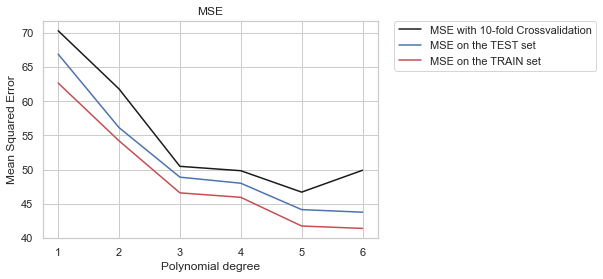

In [21]:
MSEplot(design5)

From the table below, the optimal polynomial degree is degree 5. The crossvalidation, training, and test MSE are close in value. The graph below is of the learning curves for the model with the best polynomial degree for this simplified model design: degree 5. 
The table below shows the train and test MSE for some training set sizes, for the polynomial model to degree 5. 

The differences in the test and validation MSE from this model are smaller that the MSE differences of the previous model, for the large training set sizes below. Regardless, the model suffers from high variance (overfitting), since the validation MSE is much larger than the training MSE. 

In [22]:
a = design5.at[4, 'Best Alpha']
train_sizes = range(1,1900, 10 )
learnningCurveData5, coeff = learningCurve3(X,Y,train_sizes, 5, a)
learnningCurveData5.tail(5)

,trSetSize,trMSE,valMSE
185,1851,13.364525,1376.506185
186,1861,13.494783,1082.964225
187,1871,13.518417,946.716813
188,1881,13.526709,1032.567623
189,1891,13.497890,814.567923


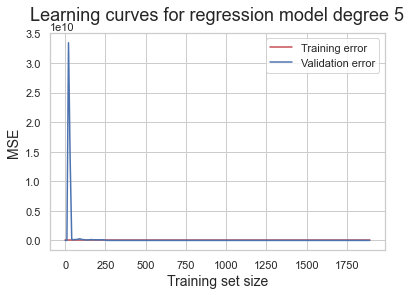

In [23]:
plt.plot(learnningCurveData5[['trSetSize']], learnningCurveData5[['trMSE']], 'r', label = 'Training error')
plt.plot(learnningCurveData5[['trSetSize']], learnningCurveData5[['valMSE']], 'b', label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model degree 5', fontsize = 18, y = 1.03)
plt.legend()

## Results and Discussion:

The table below is a summary of the important values for each optimal model explored so far. The Full Model is the model with all 11 features. Its optimal polynomial degree was found to be 1. Due to the unusual MSE vs polynomial degree graph, the adequacy of the model is questionable. Regardless, the other models have lower MSE values and higher R-squared values. 

RedModel1 is the 2nd model explored, which excluded the categorical features. The optimal polynomial degree is degree 2. The model explains about 65% of the test data variability, and about 69.8% of the training data variability. The train and test MSE are smaller than the previous model's MSE, but the crossvalidation MSE is larger.

The RedModel2 is the model with 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)' as original features, and includes the polynomial interactions. The optimal polynomial degree is degree 5. This model is the best performing so far, with the lowest MSE values, which are close to each other. The model explains about 75.7% and 78.6% of the variability from the test and training sets respectively. This model has the highest R-squared scores out of all the models.

RedModel3 is the model with 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)' as original features, excludes the polynomial interactions, and applies Ridge regression with an optimal alpha value of 1e-08. The optimal polynomial degree is degree 5. This model has lower MSE scores and higher R-squared scores than the RedModel1 model; and it has higher MSE scores and lower R-squared scores than the RedModel2 model.

In [24]:
designs = pd.DataFrame({'Full Model' :design1.iloc[design1['CVMSE'].idxmin()],
                       'RedModel 1' :design2.iloc[design2['CVMSE'].idxmin()],
                       'RedModel 2' :design3.iloc[design3['CVMSE'].idxmin()],
                       'RedModel 3' :design5.iloc[design5['CVMSE'].idxmin()]})
designs

,Full Model,RedModel 1,RedModel 2,RedModel 3
Best Alpha,NaN,NaN,NaN,1e-08
CVMSE,61.0549,63.3367,37.8821,46.691
ModelDegree,1,2,5,5
TestMSE,57.3156,49.7726,34.6163,44.1298
TrainMSE,52.826,42.3093,30.0246,41.731
test R^2,0.597834,0.650761,0.757108,0.690354
train R^2,0.62294,0.698006,0.785692,0.702134


It was previoulsy established that the models have an issue with overfitting and not underfitting, since their validation and training MSE curves need large training sample sizes to converge. Consider the table below that shows the MSE difference between the validation MSE and the training MSE for the training sizes (1851, 1861, 1871, 1881, 1891), for each of the three reduced models. The RedModel1 has its validation and training MSE curves the closest to each other, compared to the other models. The RedModel2 has its validation and training MSE curves the farthest from each other, compares to the other models. RedModel2 shows the most overfitting, and RedModel1 shows the least overfitting.

In [25]:
LClimits = pd.DataFrame({ 'TrainingSetSize' : learnningCurveData2['trSetSize'].tail(5),
                         'RedModel1' : learnningCurveData2.tail(5)['valMSE'] - learnningCurveData2.tail(5)['trMSE'],
                        'RedModel2' : learnningCurveData3.tail(5)['valMSE'] - learnningCurveData3.tail(5)['trMSE'],
                        'RedModel3' : learnningCurveData5.tail(5)['valMSE'] - learnningCurveData5.tail(5)['trMSE']})
LClimits

,TrainingSetSize,RedModel1,RedModel2,RedModel3
185,1851,112.809429,74736.661636,1363.141661
186,1861,116.326795,156652.864073,1069.469441
187,1871,124.394364,73555.814512,933.198396
188,1881,123.721230,116250.241236,1019.040915
189,1891,123.007305,58083.545093,801.070034


Joining the observations from the last two tables, RedModel1 has its crossvalidation MSE (63.3367) much larger than its training MSE (42.3093). RedModel2 is the most overfitted model, even though it has the highest R-squared scores. RedModel3 has less overfitting than RedModel2, and performs better than RedModel1 (from first table). Although RedModel3 has some indication of overfitting, overall it has the better balance between prediction capability and variance-bias ratio. The slight overfitting may not be an issue, since the R-squared values for the test and training datasets are very close together for RedModel3. The fitted RedModel3 model is written below with its estimated coefficients: 

In [26]:
print(Y.columns[0] + ' = ')
for i in list(range(0, len(coeff.columns),2)):
    if i < len(coeff.columns)-1:
        para1 = coeff.columns[i]
        estimate1 = coeff.at[0, para1]
        para2 = coeff.columns[i+1]
        estimate2 = coeff.at[0, para2]
        print( " + (" + str(round(estimate1, 8)) + ") * " + str(para1) + " + (" + str(round(estimate2, 8)) + ") * " + str(para2))
     
    else :
        para1 = coeff.columns[i]
        estimate1 = coeff.at[0, para1]
        print( " + (" + str(round(estimate1, 8)) + ") * " + str(para1) )
     
    

TransfRBC = 
 + (0.0) * 1 + (-8.23788696) * Hour
 + (0.72899318) * Temperature(°C) + (0.2628032) * Humidity(%)
 + (-1.36023096) * WindSpeed(m/s) + (2.47576023) * Hour^2
 + (0.01662834) * Temperature(°C)^2 + (0.0047931) * Humidity(%)^2
 + (0.6370744) * WindSpeed(m/s)^2 + (-0.27482551) * Hour^3
 + (-0.00063348) * Temperature(°C)^3 + (-0.00040866) * Humidity(%)^3
 + (-0.05934373) * WindSpeed(m/s)^3 + (0.01321105) * Hour^4
 + (-1.5e-07) * Temperature(°C)^4 + (6.79e-06) * Humidity(%)^4
 + (-0.01673498) * WindSpeed(m/s)^4 + (-0.00022918) * Hour^5
 + (-1.5e-07) * Temperature(°C)^5 + (-4e-08) * Humidity(%)^5
 + (0.00163397) * WindSpeed(m/s)^5


## Conclusion:

It is determined that the polynomial regression model RedModel3 with normalized features 'Hour', 'Temperature(°C)', 'Humidity(%)', and 'Wind speed (m/s)' upto the 5th degree without interactions, and regularized using ridge regression with an alpha value of 1e-08, is the most appropraite model to predict the square root of the rented bike count, out of the different model designs explored. The model does have slight signs of overfitting, but not of underfitting the training data. The model explaines about 70.2 % of the variability of the square root rented bike count from the training set, and about 69% of the variability from the test set. This model can predict the square root of the rented bike count reasonably well.

The choice to remove the 7 main features that we did helped obtain a good fit model that has a high prediction accuracy score. Rather than turning the problem into a classification problem, the choice to use polynomial regression was a good choice, since we resolved to predict the square-root of the rented bike count rather than the rented bike count itself.

## Further Questions:

It was found that RedModel2 with all the interactions has better predictive cababilities than model RedModel3 without any interactions, but the former has high variance. For future projects, the interaction effects can be explored and tested for their significance in predicting the rented bike count per hour.

With all the feature dimension reduction done, the final model has 20 features, which can be considered too many. Models can be tested with the Lasso Regression instead of the Ridge Regression, in another attempt to reduce overfitting. 

As an attempt to obtain a better prediction model, neural networks can be implemeted to create a more complex model, as long as the interpretability of the model is not necessary.

## Citations:


[1]  'Seoul Bike Sharing Demand Data Set', UCI, (2020-03). Accessed: 2021-01 https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand)

[2] Bo-eun,Kim.'Seoul's bike-sharing system gaining popularity',The Korea Times.(2016-09-19). Accessed:2021-02. https://www.koreatimes.co.kr/www/nation/2021/01/113_214248.html)

[3]  How I removed the code from the Html file: https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code